# Doberitz K-Means NDVI

We here introduce a object-oriented pipeline for search, acquiring, and manipulating Sentinel-2 scene images and bands.  Our example below uses the SatSearch API to query the _Earth on AWS_ datasets and compute the NDVI ([Normalized Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)), as well as NDVI changes over time. We built our own download script to interface with the SatSearch query results, using `boto3` and `awscli` to acquire the images locally (See Issues below).  We then computed the NDVI per set of Band4 (Red) and Band8 (NIR) images -- per time stamp per scene.  After this, we computed the K-Means clustering derived centers for both greyscale images (each NDVI separately) and for the temporal change analysis (pixel-by-pixel).  These independent metrics provide two glimpses into the spatial and temporal variations in biomass indicators for the region AOI surroudning the _Döberitzer Heide Nature Reserve_ near Berlin, DE.

<u>**K-Means**</u>  
K-Means clustering is a relatively easy method for determining the "sameness" of samples within a data set. It trains on a dataset to identify the *K* centers of distributions or clusters (i.e. the 'means').  

The high-level view of the K-Menas algorithm is as such:  
1. Compute the squared distance between each sample and all *K* (initial guess at first) cluster centers
2. Label each data point by the nearest cluster center
3. Determine the relative distance between each cluster center and the average position across all samples per cluster
4. Update each cluster center to become the average center of its own cluster
5. Repeat Steps 1-4 until convergence or a predefined maximum number of iterations.

<u>**K-Means for Remote Sensing**</u>  
With remote sensing analysis, there are are multiple methods to determine the cluster centers of an scene (of field of view):

1. If multiple bands exist over the same scene for the same time span (date-time), then the "colors per pixel" (band-to-band values) can be introduced as samples to determine the color-centers
2. If the image is grey scale, then the direct flux measurements can be used to infer a "center" for the grey scale; i.e. "black, dark grey, grey, light grey, white".
3. If multiple images of the same scene (greyscale or multibands) exist, then a temporal change analysis can be modeled using K-Means to determine the pixels over time that are most similar to each other
4. In all cases, added a meta data layer for the pixel coordinates (in lon/lat or x/y-inds) can be used to isolate regionally specific clusters; i.e. "roads in the south are different from roads in the north"

<u>**NDVI**</u>  
For our example below, we detailed methods (2) and (3) by first measuring the NDVI for each scene, followed by temporally stacking scenes to model similarities (i.e., clusters) between changes in pixels over time. NDVI is a widely used biomass indicator to determine the vegitation dominated areas of scenes. Because chlorophyll selectively absorbs Blue and Red wavelenghts, it has peaks in its solar reflectivity at Green and NIR wavelengths. In comparison, water, soil, roads, and other urban regions have a less significant solar reflectivity in the NIR. As such, a normalized difference (comparison) between the Red and NIR bands of Landsat, Sentinel, UAV, and other multi-spectral, remote observing facilities provides an indicator value to determine the biomass growth per pixel or region (i.e. AOI). See Figure 11.4 in [Huete 2004](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/spectral-reflectance).

Other biomass indicators exist, with each of their own pros and cons. See [GeoPard Agriculture](https://geopard.tech/blog/tpost/kc9y2x96kv-which-vegetation-index-is-better-to-use) for an overview.

<u>**Methods**</u>  
The object oriented package that we developed here searches and loads the data from AWS Element84 Earth Search STAC AP. [Earth Search](https://www.element84.com/earth-search/) is a "public search and discovery API for Earth on AWS datasets". It works with AWS to provide a [STAC](https://stacspec.org/) compliant API for search Sentinel-2 data products, stored on AWS. Earth Search provides a commmand line and Python api, called [Sat-Search](https://github.com/sat-utils/sat-search), to search the AWS database and download the data files to a cloud instance or local machine. 


<u>**Erratum**</u>  
**[Note]** The Sentinel-2 Earth AWS data are stored in a `request-pays` S3 bucket, which thus charges the user of Sat-Search; and thus this K-Means NDVI package. The user must have the `AWS_SECRET_ACCESS_KEY` and `AWS_ACCESS_KEY_ID` in their environment variables; as well as the `STAC_API_URL` set to `https://earth-search.aws.element84.com/v0`. Because we load the `.env` file during operations, these values can be stored and provided via a `.env` or other file using the `--env_filename` flag on the provided CLI (see below).

**[Note]** The download api that we build for this project uses `boto3`, which interfaces with the `awscli` Python package. Please ensure that you have installed and configured this package.  
1. `conda install awscli boto3`  
2. `aws configure`

**[Issue]** At the time of this writing, we were unable to use the `download` or `download_assets` methods of the satsearch api package. This situation seems to be recent and reproducible; and [GitHub Issues](https://github.com/sat-utils/sat-search/issues/123) exist to address it. We provided a `simplified_tutorial_satsearch.py` example script that follows the [Sat-Search Tutorial](https://github.com/sat-utils/sat-search/blob/276a0551c0e119b5ff1ae0731bc2bd4f63335578/tutorial-1.ipynb), with the added `download_assets` operation to verify if the api is operational. The situation could be local to our AWS credentials; but not to our local system, because we confirmed that the error also exists when using an AWS EC2 instance.

**[Solution]** As oppose to waiting for the API to become operational -- or to address our possible AWS credientials situation -- we instead elected to construct our own AWS-S3 download api that uses the Sat-Search query operations and GeoDataFrame output to deliver the required JP2 (Sentinel-2 image files) to our local machine. 

In [4]:
from dataclasses import dataclass, field
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from typing import List

In [5]:
from kmeans_ndvi import KMeansNDVI, info_message

In [6]:
@dataclass
class Params:
    """Class for KMeansNDVI Input Params"""
    geojson: str = 'doberitz_multipolygon.geojson'
    scene_id: str = None
    band_names: List[str] = field(default_factory=lambda: ['B04', 'B08'])
    collection: str = 'sentinel-s2-l2a'
    start_date: str = '2020-01-01'
    end_date: str = '2020-02-01'
    cloud_cover: float = 1
    n_sig: int = 10
    download: bool = True
    env_filename: str = '.env'
    n_clusters: int = 5
    quantile_range: List[int] = field(default_factory=lambda: [1, 99])
    verbose: bool = False
    verbose_plot: bool = False
    quiet: bool = True

clargs = Params()

In [7]:
load_dotenv(clargs.env_filename);

In [8]:
info_message("Generate JP2 KMeansNDVI Instance")
jp2_data = KMeansNDVI(
    geojson=clargs.geojson,
    start_date=clargs.start_date,
    end_date=clargs.end_date,
    cloud_cover=clargs.cloud_cover,
    collection=clargs.collection,
    band_names=[band_name_.upper() for band_name_ in clargs.band_names],
    download=clargs.download,
    n_clusters=clargs.n_clusters,
    n_sig=clargs.n_sig,
    quantile_range=clargs.quantile_range,
    verbose=clargs.verbose,
    verbose_plot=clargs.verbose_plot,
    quiet=clargs.quiet
)

INFO | utils.py:23 in info_message()
       message: 'Generate JP2 KMeansNDVI Instance'


In [9]:
info_message(jp2_data)

INFO | utils.py:23 in info_message()
       message: SentinelAOI: 
                            AOI: doberitz_multipolygon.geojson
                     Start Date: 2020-01-01
                       End Date: 2020-02-01
                Cloud Cover Max: 1
                     Collection: sentinel-s2-l2a
                     Band Names: ['B04', 'B08']


In [10]:
info_message("Downloading and acquiring images")
jp2_data.download_and_acquire_images()

INFO | utils.py:23 in info_message()
       message: 'Downloading and acquiring images'


In [11]:
info_message("Loading JP2 files into data structure")
jp2_data.load_data_into_struct()

INFO | utils.py:23 in info_message()
       message: 'Loading JP2 files into data structure'


In [12]:
info_message("Computing NDVI for all scenes")
jp2_data.compute_ndvi_for_all()

INFO | utils.py:23 in info_message()
       message: 'Computing NDVI for all scenes'
/home/jonathan/anaconda3/envs/up42/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/mnt/d/Research/Jobs/Jobs2021/Up42/DataScienceChallenge/kmeans_doberitz_sentinel_up42/kmeans_ndvi/utils.py:233: RuntimeWarning: invalid value encountered in true_divide
  ndvi_masked = np.true_divide(


In [13]:
info_message("Allocating NDVI time series")
jp2_data.allocate_ndvi_timeseries()

INFO | utils.py:23 in info_message()
       message: 'Allocating NDVI time series'


In [14]:
info_message("Computing spatial K-Means for each scene NDVI")
jp2_data.compute_spatial_kmeans()

INFO | utils.py:23 in info_message()
       message: 'Computing spatial K-Means for each scene NDVI'
WARNING | utils.py:28 in warning_message()
          message: 'NDVI cannot be computed without both Band04 and Band08'
WARNING | utils.py:28 in warning_message()
          message: 'NDVI cannot be computed without both Band04 and Band08'


In [15]:
info_message("Computing temporal K-Means for each scene NDVIs over time")
jp2_data.compute_temporal_kmeans()

INFO | utils.py:23 in info_message()
       message: 'Computing temporal K-Means for each scene NDVIs over time'


# Examine the Results

In [16]:
from kmeans_ndvi.utils import sanity_check_ndvi_statistics

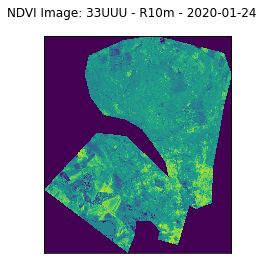

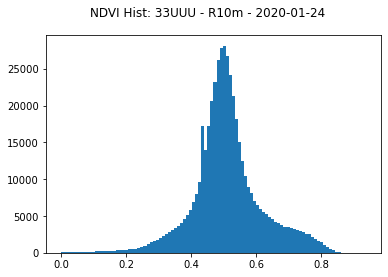

In [18]:
scene_id = '33UUU'
res = 'R10m'
date = '2020-01-24'
image = jp2_data.scenes[scene_id][res][date]['ndvi']
sanity_check_ndvi_statistics(image, scene_id, res, date, bins=100, plot_now=True)

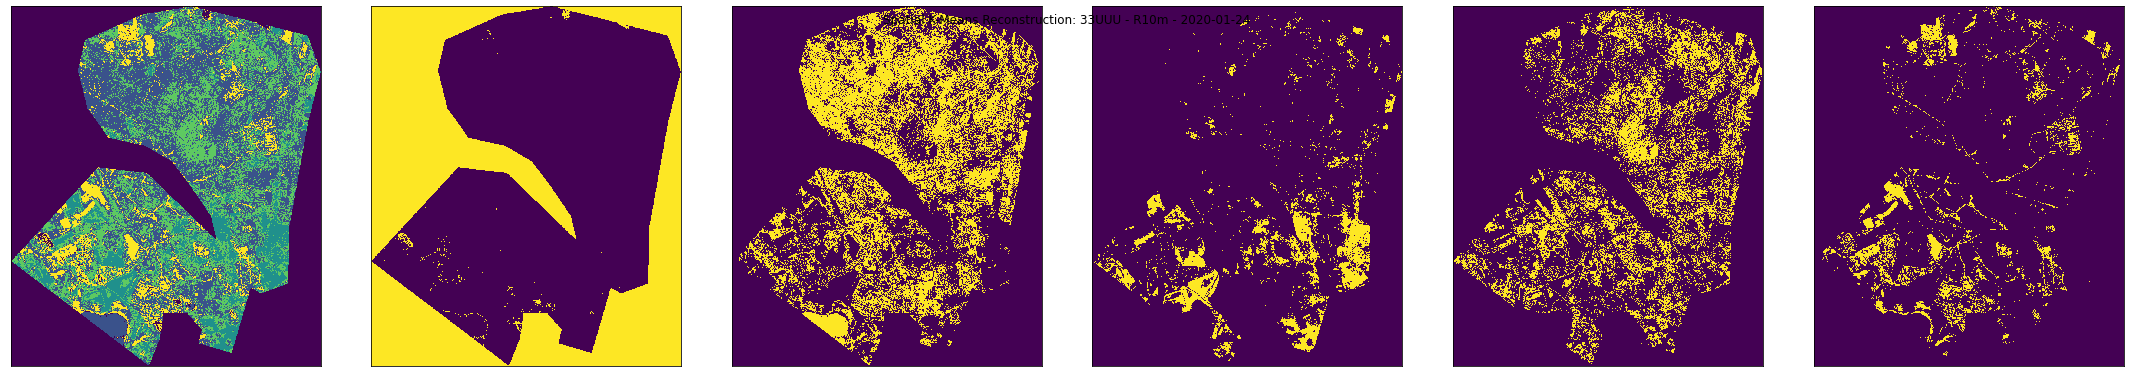

In [26]:
from kmeans_ndvi.utils import sanity_check_spatial_kmeans
scene_id = '33UUU'
res = 'R10m'
date = '2020-01-24'
image = jp2_data.scenes[scene_id][res][date]['ndvi']
kmeans = jp2_data.scenes[scene_id][res][date]['kmeans'][jp2_data.n_clusters]
sanity_check_spatial_kmeans(
    kmeans,
    image,
    jp2_data.quantile_range,
    scene_id,
    res,
    date,
    plot_now=True
)

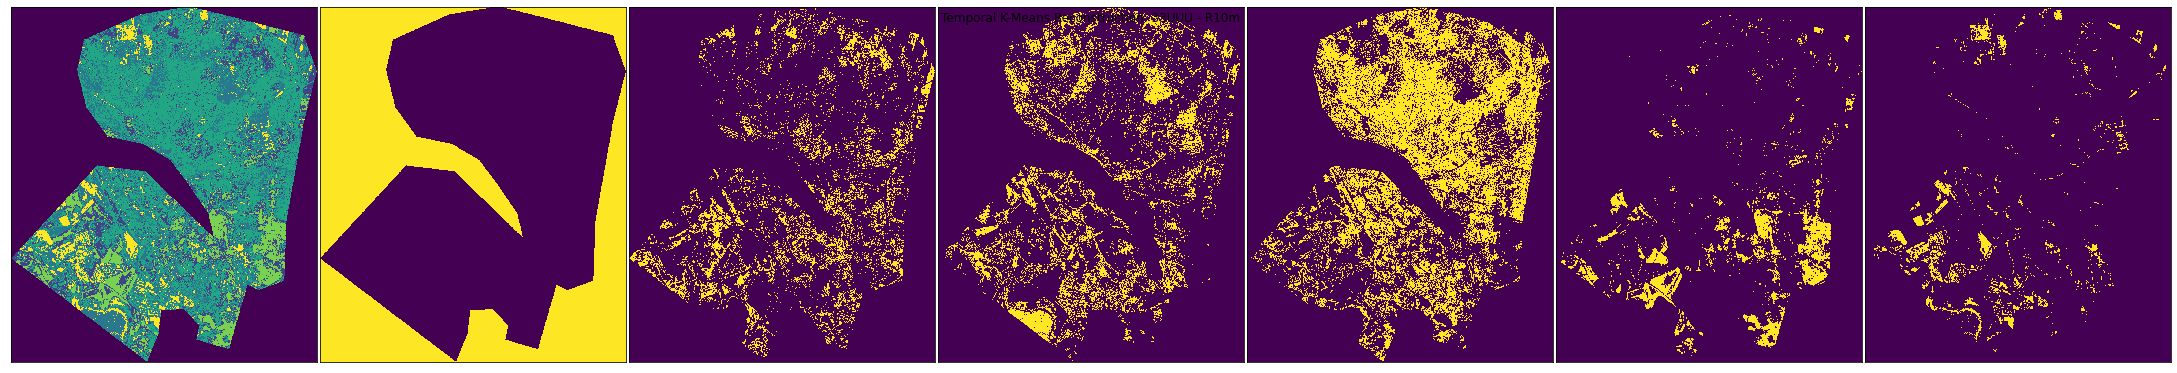

In [25]:
from kmeans_ndvi.utils import sanity_check_temporal_kmeans
scene_id = '33UUU'
res = 'R10m'
date = '2020-01-24'
image_stack = jp2_data.scenes[scene_id][res]['timeseries']['ndvi']
kmeans = jp2_data.scenes[scene_id][res]['timeseries']['kmeans'][jp2_data.n_clusters]
sanity_check_temporal_kmeans(
    kmeans,
    image_stack,
    quantile_range=jp2_data.quantile_range,
    scene_id=scene_id,
    res=res,
    plot_now=True
)